In [293]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [266]:
df = pd.read_csv('D:\\Проекты\\тестовое\\Береснев\\test_data_20210602.csv',sep=',')

In [ ]:
#ИЗУЧЕНИЕ И ПОДГОТОВКА ДАННЫХ

In [267]:
df.dtypes

AbGroup                         object
user_id                         object
time_stamp                      object
install_date                    object
event_name                      object
platform                        object
network_name                    object
country_name                    object
InGameTime                     float64
LastCompletedLevel             float64
avg_energy_amount              float64
revenue_on_event               float64
revenue_on_other_activities    float64
gold_on_event                  float64
gold_on_other_activities       float64
dtype: object

In [268]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [269]:
df['install_date'] = pd.to_datetime(df['install_date'])

In [219]:
df.shape

(703845, 15)

In [270]:
#Замена NaN на 0
df['gold_on_event'] = df.gold_on_event.fillna(0)

In [271]:
df['gold_on_other_activities'] = df.gold_on_other_activities.fillna(0)

In [272]:
df = df.fillna(0)

In [333]:
df.query('time_stamp < install_date')

Empty DataFrame
Columns: [AbGroup, user_id, time_stamp, install_date, event_name, platform, network_name, country_name, InGameTime, LastCompletedLevel, avg_energy_amount, revenue_on_event, revenue_on_other_activities, gold_on_event, gold_on_other_activities]
Index: []

In [334]:
df.query('InGameTime < 0').head(3)

AbGroup                                   user_id time_stamp  \
205   Control  dc979f3318611be7f390aa35836ecf9a09febf33 2021-04-01   
535   Control  8c835e79d133b67e46ee72bb50d5c05e125ad711 2021-03-25   
1033  Control  71dd5982f8cd06e7a92f0909cb662a9be5bca661 2021-03-25   

     install_date     event_name platform network_name  \
205    2020-05-31  ResourceSpend   itunes         Paid   
535    2020-01-20  ResourceSpend   itunes      Organic   
1033   2020-07-16  ResourceSpend   itunes         Paid   

                                           country_name    InGameTime  \
205                                              Canada -7.109405e+08   
535   United Kingdom of Great Britain and Northern I... -7.001591e+07   
1033  United Kingdom of Great Britain and Northern I... -1.199650e+09   

      LastCompletedLevel  avg_energy_amount  revenue_on_event  \
205               1299.0         236.785714               0.0   
535               1267.0          43.769231               0.0   
1033               203.0          38.600000               0.0   

      revenue_on_other_activities  gold_on_event  gold_on_other_activities  
205                           0.0            0.0                    6900.0  
535                           0.0            0.0                       0.0  
1033                          0.0         2400.0                       0.0

In [ ]:
# в датафрейме есть ошибки в данных, например, InGameTime < 0, LastCompletedLevel < 0. Оставляю все строки,
# тк в исследовании их использовать не буду.

In [335]:
sns.distplot(df.revenue_on_event)

C:\Users\ippol\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


In [336]:
sns.distplot(df.revenue_on_other_activities)

C:\Users\ippol\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


In [337]:
sns.distplot(df.gold_on_event)

C:\Users\ippol\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


In [338]:
sns.distplot(df.gold_on_other_activities)

C:\Users\ippol\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


In [ ]:
# расчет средних значений в каждой группе

In [280]:
df.query('AbGroup == "Test"').revenue_on_event.mean()

0.023318381721960487

In [283]:
df.query('AbGroup == "Control"').revenue_on_event.mean()

0.027378553539967876

In [281]:
df.query('AbGroup == "Control"').gold_on_event.mean()

126.92731384983813

In [282]:
df.query('AbGroup == "Test"').gold_on_event.mean()

135.3190122751927

In [329]:
df.query('AbGroup == "Control"').gold_on_other_activities.mean()

217.9449199521043

In [330]:
df.query('AbGroup == "Test"').gold_on_other_activities.mean()

247.46966885526692

In [284]:
df.query('AbGroup == "Test"').revenue_on_other_activities.mean()

0.11975310848350018

In [285]:
df.query('AbGroup == "Control"').revenue_on_other_activities.mean()

0.10991643065739917

In [ ]:
# делю данные на две группы

In [291]:
df_control = df.query('AbGroup == "Control"')

In [292]:
df_test = df.query('AbGroup == "Test"')

In [ ]:
# для оценки статзначимости использую бутстрап

In [317]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [327]:
booted_data = get_bootstrap(df_control.revenue_on_event, df_test.revenue_on_event, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [319]:
booted_data["p_value"]

0.05588219438798724

In [320]:
#Доверительный интервал выходит за ноль
booted_data["ci"]

0
0.025 -0.000280
0.975  0.008082

In [321]:
booted_data_revenue_on_other_activities = get_bootstrap(df_control.revenue_on_other_activities, df_test.revenue_on_other_activities, boot_it = 2000)

In [322]:
booted_data_revenue_on_other_activities["p_value"]

0.022175646976195132

In [323]:
booted_data_revenue_on_other_activities["ci"]

0
0.025 -0.018398
0.975 -0.001768

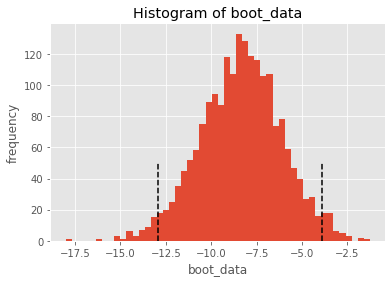

In [324]:
booted_data_gold_on_event = get_bootstrap(df_control.gold_on_event, df_test.gold_on_event, boot_it = 2000)

In [325]:
booted_data_gold_on_event["p_value"]

0.00018639099163370794

In [326]:
booted_data_gold_on_event["ci"]

0
0.025 -12.934432
0.975  -3.890035

In [328]:
booted_data_gold_on_other_activities = get_bootstrap(df_control.gold_on_other_activities, df_test.gold_on_other_activities, boot_it = 2000)

In [331]:
booted_data_gold_on_other_activities["p_value"]

9.655501649984274e-10

In [332]:
booted_data_gold_on_other_activities["ci"]

0
0.025 -39.292849
0.975 -20.526292